# <u>Exploratory Data Analysis on Raw Data</u>



As a first step in building our movie recommendation system, we begin by exploring the raw dataset to better understand the structure and content of the data. This notebook aims to provide an overview of the key variables, identify potential issues in the raw files, and highlight which aspects of the data may require processing.

Additionally, it serves to identify valuable information that can be extracted or constructed through feature engineering to enhance the quality of the recommendations.

## <u>0. Kaggle information:</u>


The dataset describes ratings and free-text tagging activities from MovieLens, a movie recommendation service. It contains 20,000,263 ratings and 465,564 tag applications across 27,278 movies. These data were created by 138,493 users between January 9, 1995 and March 31, 2015. The dataset was generated on October 17, 2016.  
Users were selected at random for inclusion. All selected users had rated at least 20 movies and no demographic information is included.  
Each user is represented by a unique `userId`.


The dataset consists of **six files**:

**`ratings.csv`**: Contains ratings of movies by users.

- userId: ID of the user  
- movieId: ID of the movie  
- rating: User-assigned score for a movie, ranging from 0.5 to 5.0 in steps of 0.5. 
- timestamp: time of the rating  

**`tags.csv`**: Contains tags applied to movies by users.

- userId: ID of the user  
- movieId: ID of the movie  
- tag: free-text tag  
- timestamp: time of tagging  

**`movies.csv`**: Contains movie information.

- movieId: ID of the movie  
- title: title of the movie  
- genres: pipe-separated list of genres  

**`links.csv`**: Contains identifiers linking MovieLens to external databases.

- movieId: ID of the movie  
- imdbId: corresponding IMDb ID  
- tmdbId: corresponding TMDb ID  

**`genome_scores.csv`**: Contains movie–tag relevance scores.

- movieId: ID of the movie  
- tagId: ID of the tag  
- relevance: strength of association between the tag and movie  

**`genome_tags.csv`**: Contains tag descriptions.

- tagId: ID of the tag  
- tag: tag text  


## <u>1. Import data and first insights on the datasets</u>

In [2]:
# Import necessary libraries
import pandas as pd, numpy as np, os, sys, seaborn as sns, matplotlib.pyplot as plt

# Set the working directory
current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import module for data processing
from modules.data_analysis import *


In [3]:
# Import dataset
rating_df = pd.read_csv('../data/raw/rating.csv', parse_dates=["timestamp"])
tag_df = pd.read_csv('../data/raw/tag.csv', parse_dates=["timestamp"])
movie_df = pd.read_csv('../data/raw/movie.csv')
link_df = pd.read_csv('../data/raw/link.csv')
genome_score_df = pd.read_csv('../data/raw/genome_scores.csv')
genome_tags_df = pd.read_csv('../data/raw/genome_tags.csv')

### <u>1.1 rating.csv</u>

As shown in the summary below, all columns appear clean and properly formatted, with no missing values or duplicates.

- `userId` and `movieId` will be used for joining datasets and constructing the interaction structure for modeling.
- `rating` serves as the main feedback signal for both the KNN baseline and the graph-based models.
- `timestamp`, while currently unused, may contain underlying patterns that could influence user behavior or rating trends.

Later in this notebook, we will examine whether the timestamp column reflects any systematic patterns, such as rating inflation over time or shifts in rating behavior across different user cohorts. If such trends are detected, we will consider extracting temporal features to enrich the model. Otherwise, the column will be safely removed.



In [4]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int64         
 1   movieId    int64         
 2   rating     float64       
 3   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 610.4 MB


In [5]:
rating_df.head(3)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39


In [6]:
# Display basic statistics of the 'rating' column
rating_df['rating'].describe()

count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [7]:
data_quality_summary(rating_df)

Missing values per column:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Number of duplicate rows:
0

Unique values per column:
userId         138493
movieId         26744
rating             10
timestamp    15351121
dtype: int64


### <u>1.2 tag.csv</u>

From the analysis of the dataset we have identified 16 missing values in the tag column, mostly from a single user. Given their small number and lack of useful content, we removed these rows as they do not contribute meaningful information to the dataset.  
The `tag` column will primarily be used to enrich the graph structure by serving as intermediary nodes between users and movies, by adding a semantic connections that go beyond simple rating information.

In [8]:
tag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465564 entries, 0 to 465563
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     465564 non-null  int64         
 1   movieId    465564 non-null  int64         
 2   tag        465548 non-null  object        
 3   timestamp  465564 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 14.2+ MB


In [9]:
tag_df.head(3)

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19


In [10]:
data_quality_summary(tag_df)

Missing values per column:
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

Number of duplicate rows:
0

Unique values per column:
userId         7801
movieId       19545
tag           38643
timestamp    425373
dtype: int64


In [11]:
# Check distribution of missing tags over users
missing_tags_summary = (
    tag_df[tag_df['tag'].isnull()]
    .groupby('userId')
    .size()
    .reset_index(name='missing_tag_count')
)

print(missing_tags_summary)


   userId  missing_tag_count
0  116460                 15
1  133634                  1


### <u>1.3 movie.csv</u>

From a quick analysis of the dataset, we observe that there are no missing values or duplicate rows.  
- `title`: While the title column does not provide additional modeling value beyond the movieId, it will be useful later for interpretation and visualization of the results.    
- `genre`: Similar to the tag column in the previous dataframe, genre will play a key role in enriching the semantic structure of the graph and enhancing the similarity relationships between movies. Given its multi-label nature, we will later process it either through multi-hot encoding or by expanding each movie into multiple rows, each associated with a single genre.

In [12]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [13]:
movie_df.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [14]:
data_quality_summary(movie_df)

Missing values per column:
movieId    0
title      0
genres     0
dtype: int64

Number of duplicate rows:
0

Unique values per column:
movieId    27278
title      27262
genres      1342
dtype: int64


### <u>1.4 link.csv</u>

Given the nature of the project, we can ignore the link.csv file, as our goal is not to include external information from other databases. This file could be useful in future applications, in combination with web scraping or APIs, to expand the dataset with additional metadata or reviews.

#### <u>1.5 genome_scores.csv</u>

The genome_scores.csv file will be useful for linking tags to movies using weighted relevance scores. This helps identify similar movies based on shared tag profiles and adds more meaningful connections between movies. There are no missing values or duplicates, and the format and value range look correct.

In [15]:
genome_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 268.0 MB


In [16]:
genome_score_df.head(3)

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775


In [17]:
genome_score_df["relevance"].describe()

count    1.170977e+07
mean     1.164833e-01
std      1.542463e-01
min      2.500000e-04
25%      2.425000e-02
50%      5.650000e-02
75%      1.415000e-01
max      1.000000e+00
Name: relevance, dtype: float64

In [18]:
data_quality_summary(genome_score_df)

Missing values per column:
movieId      0
tagId        0
relevance    0
dtype: int64

Number of duplicate rows:
0

Unique values per column:
movieId      10381
tagId         1128
relevance     4000
dtype: int64


### <u>1.6 genome_tags.csv</u>

This dataset will allow us to maps each tagId to its corresponding tag text. It will be used to merge readable tag names with the relevance scores in genome_scores.csv. As expected, the tagId values match between the two files.

In [19]:
genome_tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


In [20]:
genome_tags_df.head(3)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century


In [21]:
data_quality_summary(genome_tags_df)

Missing values per column:
tagId    0
tag      0
dtype: int64

Number of duplicate rows:
0

Unique values per column:
tagId    1128
tag      1128
dtype: int64


## <u>2. Explanatory analysis</u>

### <u>2.1 Rating Distribution</u>

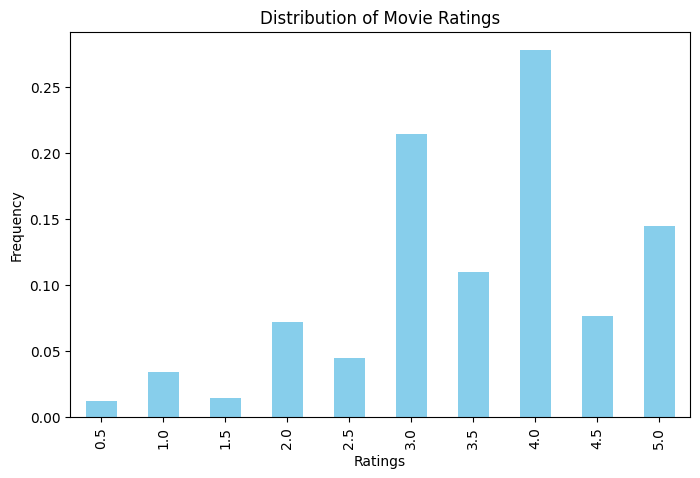

In [43]:
# Build bar plot for the rating distribution
plt.figure(figsize=(8, 5))
rating_counts = rating_df['rating'].value_counts(normalize=True).sort_index()
rating_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


<u>Comment:</u>

As we can observe from the bar plot, there is a noticeable skew toward higher ratings, with 4.0 being the most frequent. This likely reflects a combination of psychological tendencies and selection bias. One possible explanation is that users tend to rate movies they enjoyed, while avoiding those they disliked or found forgettable.

Additionally, a rating of 3.0, although numerically near the midpoint of the scale, often reflects a neutral or indifferent opinion rather than a truly positive one. This distinction should be considered in the implementation of the recommendation system, for example by treating ratings ≥ 4.0 as positive (worth recommending) and those ≤ 3.5 as negative or neutral.

### <u>2.2 Users activities</u>

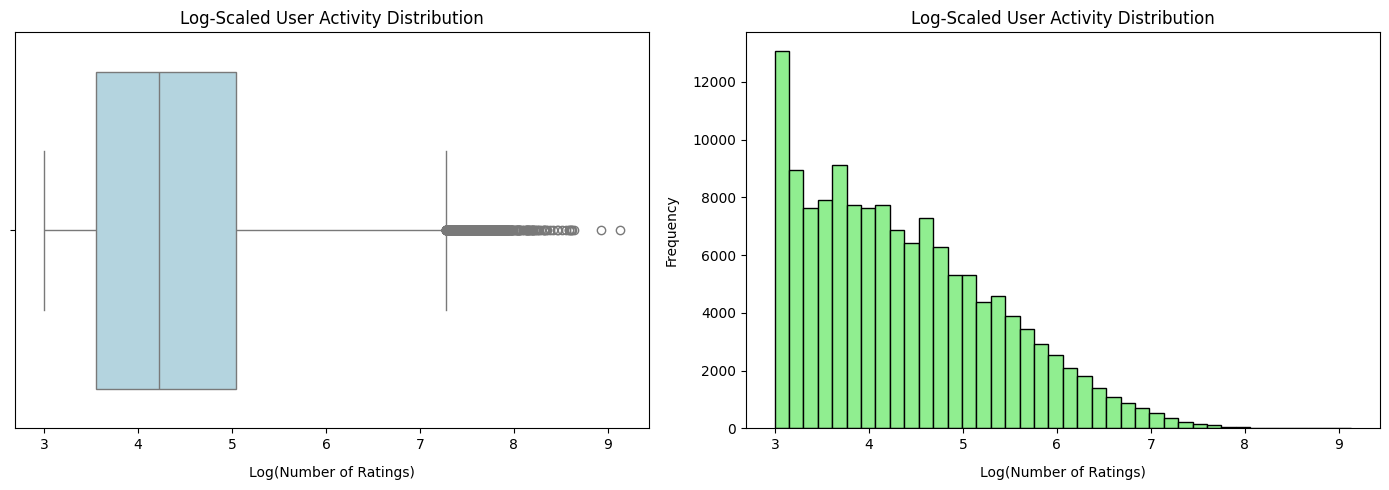

In [47]:
# Compute the original and log-scaled distribution of user activity
user_rating_counts = rating_df['userId'].value_counts()
log_counts = np.log(user_rating_counts)

# Plot histogram and boxplot for user activity
fig,axes = plt.subplots(1,2,figsize=(14,5))

# Boxplot for user activity
sns.boxplot(x=log_counts, ax=axes[0], color='lightblue')
axes[0].set_title('Log-Scaled User Activity Distribution')
axes[0].set_xlabel('Log(Number of Ratings)', labelpad=10)


# Histogram for log-scaled user activity
axes[1].hist(log_counts, bins=40, color = 'lightgreen', edgecolor='black')
axes[1].set_title('Log-Scaled User Activity Distribution')
axes[1].set_xlabel('Log(Number of Ratings)', labelpad=10)
axes[1].set_ylabel('Frequency', labelpad=10)
plt.tight_layout()
plt.show()

In [48]:
print(f'Summary user activity distribution:\n'
      f'mean: {user_rating_counts.mean():.2f}\n'
      f'median: {user_rating_counts.median():.2f}\n'
      f'std : {user_rating_counts.std():.2f}\n'
      f'min : {user_rating_counts.min():.2f}\n'
      f'max : {user_rating_counts.max():.2f}\n')

Summary user activity distribution:
mean: 144.41
median: 68.00
std : 230.27
min : 20.00
max : 9254.00



<u>Comment:</u>

From the histogram, boxplot, and summary, we can clearly see that user activity is very right-skewed, meaning that a small number of users gave a very large number of reviews compared to the general trend. The log transformation was applied to help visualize this better by reducing the dispersion and making the upper tail more readable. Based on the statistics, we also confirm that users with fewer than 20 ratings were already removed from the dataset, which helps reduce noise and keep only users with meaningful contributions. Overall, the dataset looks quite balanced, with enough active users to support stable and informative recommendation training.



### <u> 2.3 Insights on genres <u>

In [54]:
# First we split the genres (..|..|..) into a list of genres
movie_df['genre_list'] = movie_df['genres'].str.split('|')

# Explode the genre_list to have one genre per row
movies_exploded = movie_df.explode('genre_list')

# Merge movies_exploded with rating_df to get the ratings for each genre
rating_genre_df = pd.merge(rating_df,movies_exploded[['movieId', 'genre_list']], on = 'movieId', how='left')
rating_genre_df.head(3)

,userId,movieId,rating,timestamp,genre_list
0,1,2,3.5,2005-04-02 23:53:47,Adventure
1,1,2,3.5,2005-04-02 23:53:47,Children
2,1,2,3.5,2005-04-02 23:53:47,Fantasy


#### <u> 2.3.1 Top 10 highest rated genre </u>


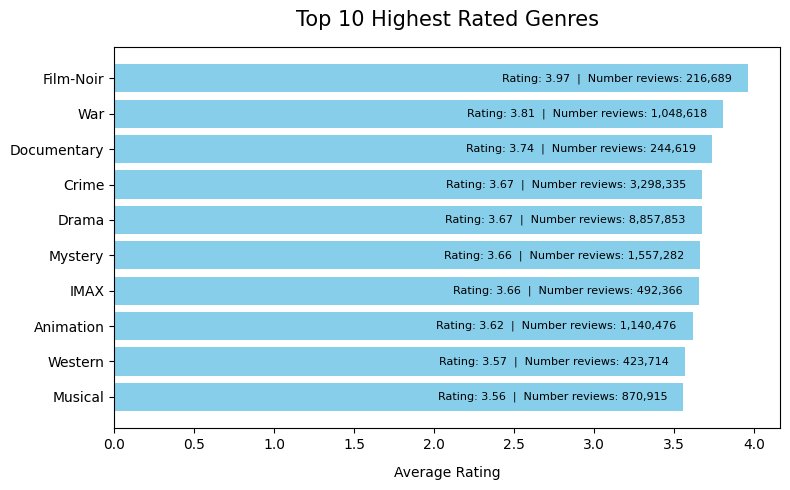

In [ ]:
# Find the top 10 highest rated genres and the number of reviews for each genre
top_genres = rating_genre_df.groupby('genre_list')['rating'].agg(['mean', 'count']).sort_values(by='mean', ascending=False).head(10)

fig, ax = plt.subplots(figsize = (8,5))

# Barplot for the top 10 genres
bars = ax.barh(top_genres.index, top_genres['mean'], color='skyblue')
ax.invert_yaxis()

# Add info inside the bar
for bar,count in zip(bars, top_genres['count']):
    # width = averagerating 
    width = bar.get_width()
    ax.text(
        width - 0.1,
        bar.get_y() + bar.get_height() / 2,
        f'Rating: {width:.2f}  |  Number reviews: {int(count):,}',
        va='center',
        ha='right',
        color='black',
        fontsize=8
    )


ax.set_title('Top 10 Highest Rated Genres', fontsize=15, pad=15)
ax.set_xlabel('Average Rating', labelpad=10); ax.set_ylabel('')
plt.tight_layout()
plt.show()